# Предсказание коэффициента восстановления золота из золотосодержащей руды. 

## Загрузка библиотек. Знакомство с данными

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
state = np.random.RandomState(24)
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import make_scorer
from scipy import stats as st
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 
from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyRegressor

from sklearn.metrics import f1_score 
from sklearn.preprocessing import StandardScaler 
pd.options.mode.chained_assignment = None
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve 
pd.set_option('display.max_columns',500)
import collections

from sklearn.model_selection import cross_val_score

from sklearn.base import BaseEstimator
from sklearn.pipeline import  make_pipeline
from sklearn.pipeline import  Pipeline

from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.svm import SVR

In [2]:
from sklearn.impute import KNNImputer

import warnings
warnings.filterwarnings("ignore")

In [3]:
# считываем датафрейм
try:
    df_full = pd.read_csv('C:\\\\Python\\\\ЯП\\\\Сборный_проект_2\\\\gold_recovery_full_new.csv', sep=',')
    df_test = pd.read_csv('C:\\\\Python\\\\ЯП\\\\Сборный_проект_2\\\\gold_recovery_test_new.csv', sep=',')
    df_train = pd.read_csv('C:\\\\Python\\\\ЯП\\\\Сборный_проект_2\\\\gold_recovery_train_new.csv', sep=',')
    

except:
    df_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv', sep=',')
    df_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv', sep=',')
    df_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv', sep=',')

Оценим размер данных

In [4]:
# полный объем данных

df_full.shape

(19439, 87)

In [5]:
# тестовый объем данных

df_test.shape

(5290, 53)

In [6]:
# тренировочный объем данных

df_train.shape

(14149, 87)

Тренировочный датасет и полный датасет отличаются кол-вом строк, но не столбцов.
В тестовом датасете кол-во столбцов меньше

In [7]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


Все значения float64, кроме даты

In [10]:
df_full.head(3)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [11]:
df_test.head(3)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559


In [12]:
df_train.head(3)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

первый столбец date отлично подойдет как id

посмотрим на кол-во пропусков в данных

In [13]:
df_train.isnull().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

In [14]:
df_test.isnull().sum()

date                                           0
primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatb

In [15]:
df_full.isnull().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

Выводы: есть пропуски в данных. В тестовом датасете меньшее кол-во признаков , чем в полном или тренировочном

## Подготовка данных

### Проверим, что эффективность обогащения рассчитана правильно.

#### Черновой концентрат

In [16]:
Recovery_start = df_train['rougher.output.recovery'] #Эффективность обогащения чернового концентрата
Recovery_start.mean()

82.70450164550267

In [17]:
Recovery_fin = df_train['final.output.recovery'] #Эффективность обогащения финального концентрата
Recovery_fin.mean()

66.51883212756596

Эффективность обогащения на финальной стадии ниже чем в начале

In [18]:
C_start = df_train["rougher.output.concentrate_au"]   #доля золота в черновом концентрате после очистки;
C_start.mean()

19.439957851436542

In [19]:
C_fin = df_train['final.output.concentrate_au']   #доля золота в финальном концентрате после очистки;
C_fin.mean()

44.00379162105556

доля золота в черновом концентрате закономерно ростет приближаясь к финальной стадии

In [20]:
T_start = df_train['rougher.output.tail_au'] # доля золота в хвостах чернового концентрата после чистки;
T_start.mean()

1.757473291465481

In [21]:
T_fin =  df_train['final.output.tail_au']# доля золота в хвостах финального концентрата после чистки;
T_fin.mean()

2.91842077457981

Таким образом провели качественное исследования эффективности обогащения. Из увиденного можем сделать выводы:
    
   - эффективность обогащения падает к концу производственного цикла,
    
   - доля золота в концентрате и хвостах ростет по мере прохождения производственного цикла

Доля золота в хвостах, так же ростет, с ростом удельной доли золота в концентрате , что вообщем закономерно в следствии увеличения концентрата на входе и снижения эффективности обогащения

In [22]:
F_start = df_train['rougher.input.feed_au'] # доля золота в черновом концентрате до флотации/очистки;
F_start

0        6.486150
1        6.478583
2        6.362222
3        6.118189
4        5.663707
           ...   
14144    5.335862
14145    4.838619
14146    4.525061
14147    4.362781
14148    4.365491
Name: rougher.input.feed_au, Length: 14149, dtype: float64

### Эффективность обогащения 

Проверим эффективность обогащения

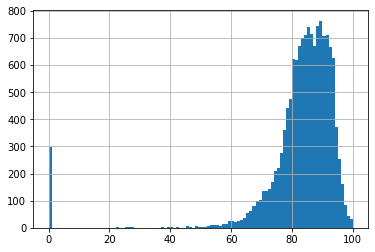

In [23]:
Recovery_calc=(C_start*(F_start-T_start))/(F_start*(C_start-T_start))*100
Recovery_calc.hist(bins=100);

In [24]:
Recovery_calc

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Length: 14149, dtype: float64

### Найдём MAE между полученным рассчетным значением и исходными данными.

In [25]:
mean_absolute_error(Recovery_calc,Recovery_start)

9.682896147825551e-15

получилось ооооочень маленькое число - считаем что ошибки нет

Выводы: Эффективность обогащения рассчитана верно! 

### Проанализируем признаки, недоступные в тестовой выборке.

Выделим клонки отсутствующие в тестовой выборке

In [26]:
df_full_copy=df_full.copy()

for i in df_test.columns:
    df_full_copy=df_full_copy.drop(i, axis=1)

In [27]:
df_full_copy.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,41885.707031,3481.779053,3520.337158,2.838687,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,14.500184,4.694824,8.764648,2.606185
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,8.558743,10.497069,19.369147,34.118526,16.250511,3.049646,6.733907,2.353017,42050.861809,3498.370979,3489.981857,2.858998,11.615865,7.278807,28.067063,20.050975,86.843261,4.955378,0.536689,18.965234,1.184827,14.265474,4.592547,9.001494,2.488248
2,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,8.603505,10.354494,19.167579,33.969464,16.491823,3.124664,6.471768,2.416800,42018.101184,3495.348910,3502.359819,2.945989,11.695753,7.216833,27.454037,19.737170,86.842308,4.843460,0.546416,18.808533,1.162562,14.115662,4.624775,8.842896,2.458187
3,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,7.221879,8.496563,15.978538,28.260743,16.024359,2.960362,6.843791,2.262051,42029.447991,3498.578313,3499.162912,3.002340,11.915047,7.175616,27.341277,19.320810,87.226430,4.655288,0.542525,19.330200,1.079755,13.732071,4.482453,9.122857,2.322062
4,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,9.089428,9.986786,19.199864,33.044932,16.480185,3.112100,6.550154,2.277073,42125.354245,3494.800771,3506.679315,3.169615,12.411054,7.240205,27.041023,19.216101,86.688794,4.552800,0.515438,19.267422,1.012642,14.079996,4.470737,8.871028,2.330448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19434,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,6.559174,12.445966,7.056338,32.940215,22.854592,6.531541,3.934320,2.314352,45912.942619,2497.652954,2499.177950,1.155559,11.124896,10.984003,30.068876,18.603550,89.574376,4.207261,0.612935,16.666590,0.748633,0.000000,0.000000,0.000000,0.000000
19435,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,6.612376,12.623947,7.542264,32.925325,23.002490,6.629725,4.089124,2.462890,46200.099585,2614.403937,2518.550078,1.167342,11.425983,10.888213,29.783972,18.441436,87.724007,4.177943,0.650557,16.960649,0.771582,0.000000,0.000000,0.000000,0.000000
19436,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,7.128896,12.633558,7.941900,31.856742,22.298149,6.278250,4.457457,2.612231,44585.181334,2510.813545,2510.142433,1.125637,8.523497,8.955135,22.786467,15.111231,88.890579,4.050010,0.636095,18.323080,0.685059,0.000000,0.000000,0.000000,0.000000
19437,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,7.490444,12.012378,6.942972,30.770892,22.714656,6.253145

In [28]:
columns_list=list(df_full_copy.columns)
columns_list

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

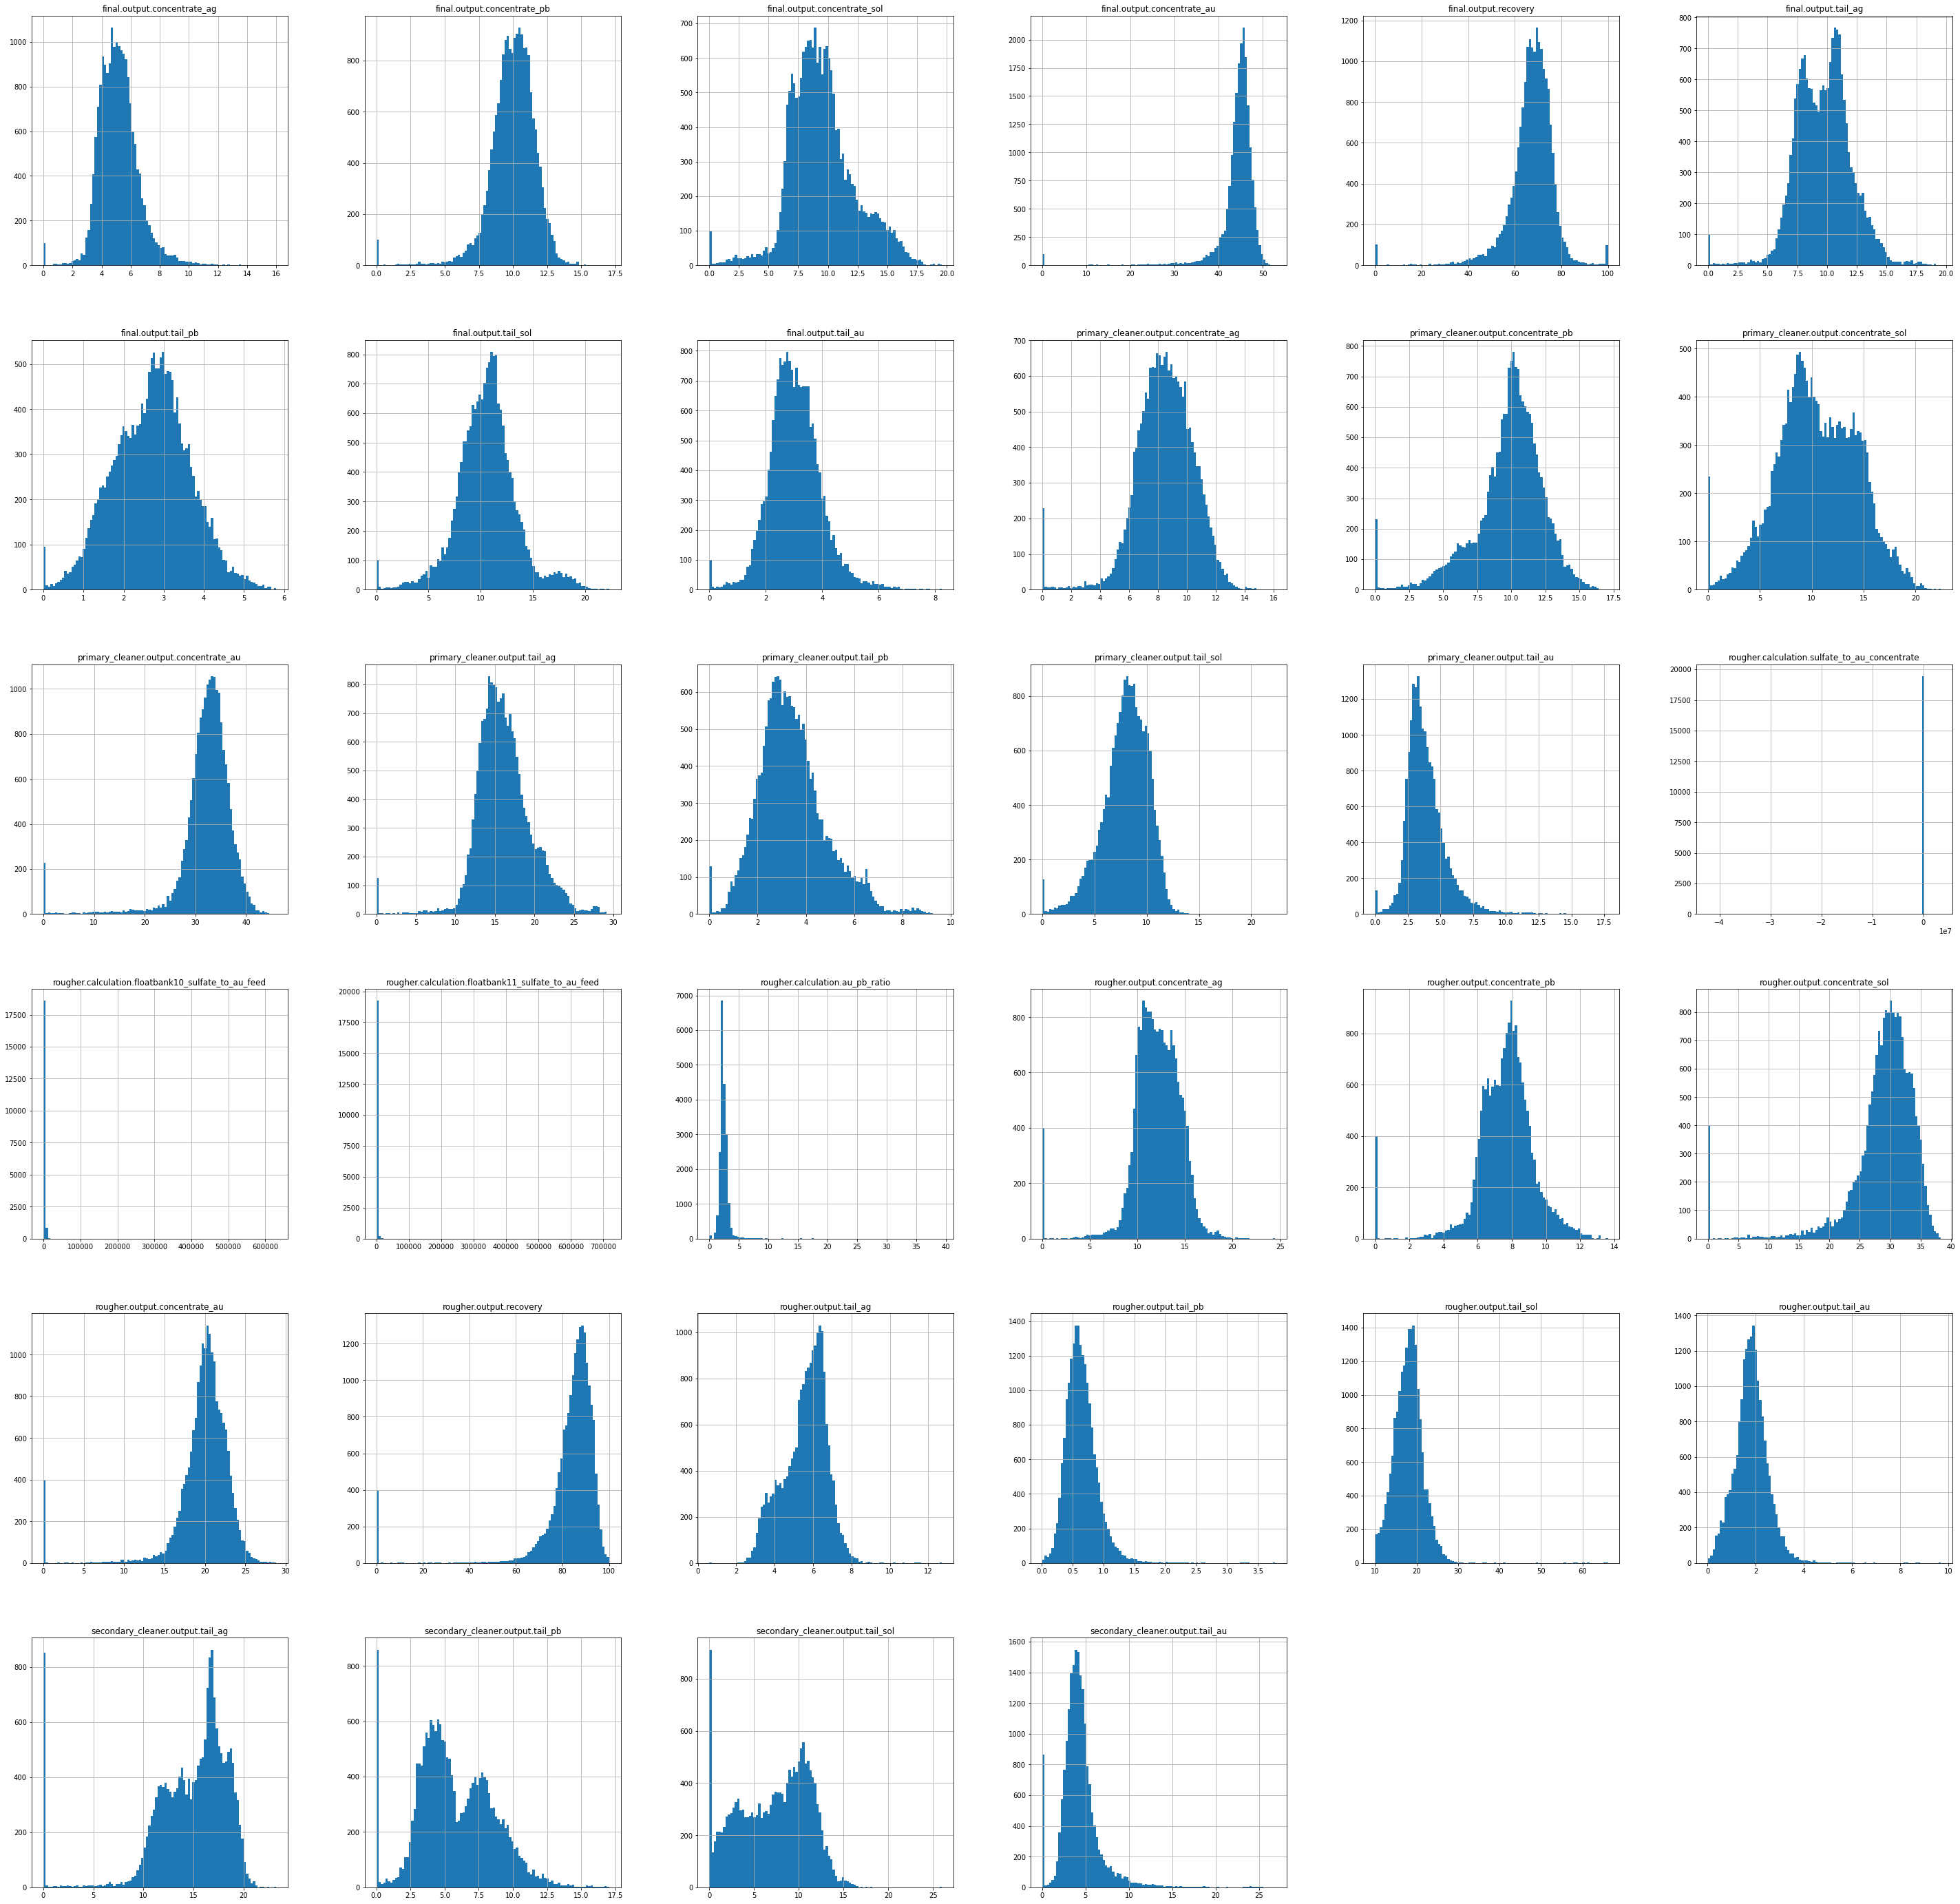

In [29]:
df_full_copy.hist(bins=100,figsize=(50,50));

In [30]:
df_full_copy.boxplot(figsize=(150,150));

Эти столбцы практически полностью состоят из нулей:
  - rougher.calculation.sulfate_to_au_concentrate,
  - rougher.calculation.floatbank10_sulfate_to_au_feed,
  - rougher.calculation.floatbank11_sulfate_to_au_feed'


- rougher.calculation.sulfate_to_au_concentrate + слишком большие выбросы


In [31]:
df_full_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                                19439 non-null  float64


все float64

Проанализируем наименование колонок чтобы понять что в них 

In [32]:
step = collections.Counter()
type_step = collections.Counter()
data = collections.Counter()

In [33]:
for i in columns_list:
    words = list(map(str,i.split(".")))
    step[words[0]] += 1
    type_step[words[1]] += 1
    data[words[2]] += 1

In [34]:
step

Counter({'final': 9,
         'primary_cleaner': 8,
         'rougher': 13,
         'secondary_cleaner': 4})

In [35]:
type_step

Counter({'output': 30, 'calculation': 4})

In [36]:
data

Counter({'concentrate_ag': 3,
         'concentrate_pb': 3,
         'concentrate_sol': 3,
         'concentrate_au': 3,
         'recovery': 2,
         'tail_ag': 4,
         'tail_pb': 4,
         'tail_sol': 4,
         'tail_au': 4,
         'sulfate_to_au_concentrate': 1,
         'floatbank10_sulfate_to_au_feed': 1,
         'floatbank11_sulfate_to_au_feed': 1,
         'au_pb_ratio': 1})

In [37]:
df_full_copy.isnull().sum()

final.output.concentrate_ag                              1
final.output.concentrate_pb                              1
final.output.concentrate_sol                           211
final.output.concentrate_au                              0
final.output.recovery                                    0
final.output.tail_ag                                     1
final.output.tail_pb                                   101
final.output.tail_sol                                    6
final.output.tail_au                                     0
primary_cleaner.output.concentrate_ag                    0
primary_cleaner.output.concentrate_pb                  116
primary_cleaner.output.concentrate_sol                 370
primary_cleaner.output.concentrate_au                    0
primary_cleaner.output.tail_ag                           4
primary_cleaner.output.tail_pb                          21
primary_cleaner.output.tail_sol                         62
primary_cleaner.output.tail_au                          

Выводы:

Пропущенные параметры можно разбить на категории: 
   - этап обрабки : 'final': 9, 'primary_cleaner': 8, 'rougher': 13, 'secondary_cleaner': 4
   - тип параметра : 'output': 30, 'calculation': 4
   - тип данных : 'concentrate_ag': 3,'concentrate_pb': 3, 'concentrate_sol': 3, 'concentrate_au': 3,'recovery':2,'tail_ag': 4,'tail_pb': 4,'tail_sol': 4, 'tail_au': 4, 'sulfate_to_au_concentrate': 1, 'floatbank10_sulfate_to_au_feed':1, 'floatbank11_sulfate_to_au_feed': 1, 'au_pb_ratio': 1
        
        
        
1) наиболее популярным типом данных по **этапу обработки** является: грубая обработка (rougher : 13)

2) наиболее популярным типом данных по **типу параметра** является: выходные данные (output : 30)

3) наиболее популярным типом данных по **типу данных** является: хвосты (tail_ag/pb/...': 4)


Есть пропуски

### 1.4. Проведите предобработку данных.

Рассмотрим пропуски в полном датасете

Составим датафрейм в котором укажем кол-во пропусков и какой процент от общего объема пропуски составляют

In [38]:
isnull_df_full = df_full.isnull().sum()
isnull_df_full_mean = df_full.isnull().mean()

isnull_df_full = pd.DataFrame([isnull_df_full],index=['sum_Nan']).T
isnull_df_full_mean = pd.DataFrame([isnull_df_full_mean],index=['mean']).T

isnull_df_full.reset_index(level=0, inplace=True)
isnull_df_full_mean.reset_index(level=0, inplace=True)
isnull_df_full

isnull_df_full=isnull_df_full.merge(isnull_df_full_mean, on=['index'], how='outer')

isnull_df_full = isnull_df_full[isnull_df_full['sum_Nan']>0]
isnull_df_full.sort_values('sum_Nan').tail(40)

,index,sum_Nan,mean
6,final.output.tail_ag,1,0.000051
23,primary_cleaner.state.floatbank8_a_level,1,0.000051
25,primary_cleaner.state.floatbank8_b_level,1,0.000051
27,primary_cleaner.state.floatbank8_c_level,1,0.000051
30,rougher.calculation.sulfate_to_au_concentrate,2,0.000103
26,primary_cleaner.state.floatbank8_c_air,2,0.000103
85,secondary_cleaner.state.floatbank6_a_air,2,0.000103
65,secondary_cleaner.output.tail_ag,2,0.000103
31,rougher.calculation.floatbank10_sulfate_to_au_...,2,0.000103
32,rougher.calculation.floatbank11_sulfate_to_au_...,2,0.000103


Оценим кол-во признаков с незначительными пропусками в данных, которые мы удалим.

In [39]:
isnull_df_full[isnull_df_full['sum_Nan']<100].count()

index      52
sum_Nan    52
mean       52
dtype: int64

Оценим кол-во признаков с значительными пропусками в данных, которые мы заполним.

In [40]:
isnull_df_full[isnull_df_full['sum_Nan']>100].count()

index      10
sum_Nan    10
mean       10
dtype: int64

Пропуски условно разбиваем на 2 группы: 
  - больше 100 - эти заполоняем
  - меньше 100 - эти удаляем

drop_list - это список колонок пропуски в данных в которых можно удалить

In [41]:
drop_list=list(isnull_df_full[isnull_df_full['sum_Nan']<100]['index'].values)

restore_list - это список колонок пропуски в данные в которых нужно заполнить

In [42]:
restore_list=list(isnull_df_full[isnull_df_full['sum_Nan']>100]['index'].values)

проверим размерность перед процессом удаления

In [43]:
df_full.shape

(19439, 87)

In [44]:
for i in drop_list:
    df_full=df_full.drop(df_full[(df_full[i].isnull()==True)].index)
    df_train=df_train.drop(df_train[(df_train[i].isnull()==True)].index)


In [45]:
for i in drop_list:
    try:
        df_test=df_test.drop(df_test[(df_test[i].isnull()==True)].index)
    except:
        pass

проверим размерность после процесса удаления

In [46]:
df_full.shape

(19119, 87)

произошла незначительная потеря в 320 сточек. Считаем это приемлимым.

Посмотрим на фичи с большим кол-вом пропусков

In [47]:
df_full[restore_list].isnull().sum()

final.output.concentrate_sol                 194
final.output.tail_pb                         100
primary_cleaner.input.xanthate                83
primary_cleaner.output.concentrate_pb         82
primary_cleaner.output.concentrate_sol       293
rougher.input.feed_size                      138
rougher.input.floatbank11_xanthate           391
rougher.state.floatbank10_e_air              427
secondary_cleaner.output.tail_sol           1652
secondary_cleaner.state.floatbank2_a_air     208
dtype: int64

Перед тем как из заполнять, примерджим к тестовому датафрейму пару фичей необходимых для обучения модели

In [48]:
df_test=df_test.merge(df_full[['date','rougher.output.recovery', 'final.output.recovery']], on=['date'], how='left')
df_test

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,89.993421,70.273583
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,88.089657,68.910432
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,88.412756,68.143213
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.5

#### Заполним пропуски

In [50]:
df_full=df_full.fillna(method='ffill')

In [51]:
df_train=df_train.fillna(method='ffill')

In [52]:
df_test=df_test.fillna(method='ffill')

In [55]:
df_full.isnull().sum()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

In [56]:
df_test.isnull().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

In [57]:
df_train.isnull().sum()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

In [58]:
df_test.shape

(5246, 55)

In [59]:
df_full.shape

(19119, 87)

In [60]:
df_train.shape

(13895, 87)

Выводы: Пропуски в данных заполнены и(или) удалены

## Анализ данных
### Изменение концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

In [61]:
df_full[['rougher.output.concentrate_au','primary_cleaner.output.concentrate_au','final.output.concentrate_au']].describe()

,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
count,19119.000000,19119.000000,19119.000000
mean,19.790220,32.151578,44.218935
std,3.719045,5.528323,4.672843
min,0.000000,0.000000,0.000000
25%,18.814057,30.479819,43.452289
50%,20.282206,32.838610,45.026128
75%,21.713505,35.038251,46.288209
max,28.824507,45.933934,52.756638


In [62]:
df_full[['rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag','final.output.concentrate_ag']].describe()

,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag
count,19119.000000,19119.000000,19119.000000
mean,12.003845,8.461146,5.167410
std,2.713056,2.031984,1.342196
min,0.000000,0.000000,0.000000
25%,10.636270,7.281065,4.251880
50%,12.105544,8.522308,5.063004
75%,13.735370,9.815341,5.883120
max,21.725695,16.081632,16.001945


In [63]:
tabl_pb=df_full[['rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb','final.output.concentrate_pb']].describe()
tabl_pb

,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb
count,19119.000000,19119.000000,19119.000000
mean,7.603819,9.841854,9.997786
std,1.782331,2.544443,1.606364
min,0.000000,0.000000,0.000000
25%,6.726099,8.716014,9.145656
50%,7.741370,10.158470,10.103451
75%,8.559261,11.427481,11.036372
max,12.797765,17.081278,17.031899


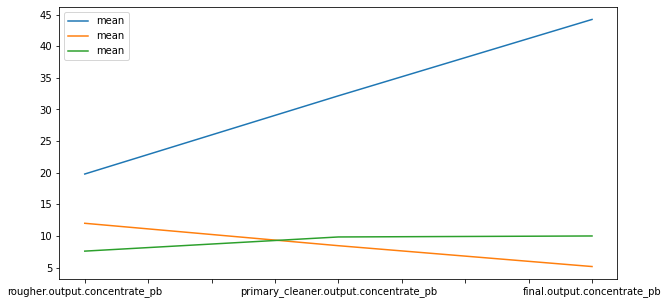

In [64]:
desc_pb = df_full[['rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb',
                   'final.output.concentrate_pb']].describe().T

desc_au = df_full[['rougher.output.concentrate_au','primary_cleaner.output.concentrate_au',
                   'final.output.concentrate_au']].describe().T

desc_ag = df_full[['rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag',
                   'final.output.concentrate_ag']].describe().T



desc_au['mean'].plot(figsize=(10,5),legend=('au'));
desc_ag['mean'].plot(figsize=(10,5),legend=('ag'));
desc_pb['mean'].plot(figsize=(10,5),legend=('pb'));


In [65]:
df_full['rougher.output.concentrate_au'].mean()

19.790220242683343

In [66]:
df_full['rougher.output.concentrate_pb'].mean()

7.603819070772604

In [67]:
df_full['rougher.output.concentrate_ag'].mean()

12.003844681532149

In [68]:
df_full['primary_cleaner.output.concentrate_au'].mean()

32.151577826231694

In [69]:
df_full['primary_cleaner.output.concentrate_pb'].mean()

9.841853643804658

In [70]:
df_full['primary_cleaner.output.concentrate_ag'].mean()

8.461146251736928

In [71]:
df_full['final.output.concentrate_au'].mean()

44.21893480498579

In [72]:
df_full['final.output.concentrate_pb'].mean()

9.997785890209688

In [73]:
df_full['final.output.concentrate_ag'].mean()

5.167409965803565

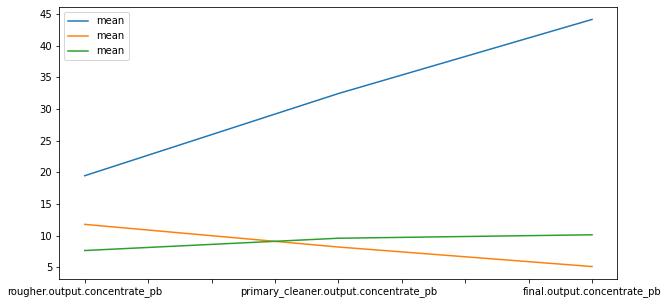

In [74]:
desc_pb = df_train[['rougher.output.concentrate_pb','primary_cleaner.output.concentrate_pb',
                   'final.output.concentrate_pb']].describe().T

desc_au = df_train[['rougher.output.concentrate_au','primary_cleaner.output.concentrate_au',
                   'final.output.concentrate_au']].describe().T

desc_ag = df_train[['rougher.output.concentrate_ag','primary_cleaner.output.concentrate_ag',
                   'final.output.concentrate_ag']].describe().T



desc_au['mean'].plot(figsize=(10,5),legend=('au'));
desc_ag['mean'].plot(figsize=(10,5),legend=('ag'));
desc_pb['mean'].plot(figsize=(10,5),legend=('pb'));

Выводы: 
  - концентрация золота по мере обработки увеличивается 
  - концентрация pb возрастает после первой ступени очистки, в дальнейшем увеличение концентрации незначительное
  - концентрация ag падает по мере обработки

### Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. 

#### Cравнение гранул после первичной обработки.

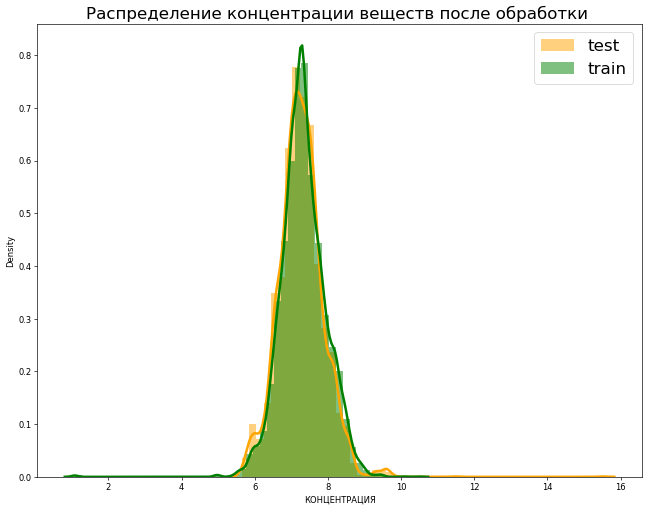

In [75]:
plt.figure(figsize=(13,10), dpi= 60)
sns.distplot(df_test['primary_cleaner.input.feed_size'], color="orange", label="test",
             hist_kws={'alpha':.5}, kde_kws={'linewidth':3})

sns.distplot(df_train['primary_cleaner.input.feed_size'], color="g", label="train",
             hist_kws={'alpha':.5}, kde_kws={'linewidth':3},axlabel='КОНЦЕНТРАЦИЯ')

plt.title('Распределение концентрации веществ после обработки ', fontsize=20)
plt.legend(fontsize=20)
plt.show()

<AxesSubplot:>

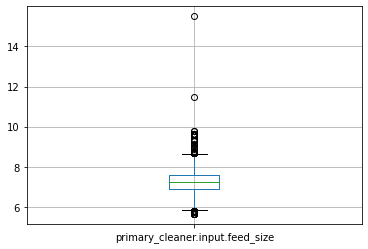

In [76]:
df_test[['primary_cleaner.input.feed_size']].boxplot();

Наблюдаем 2 больших выброса в положительную сторону - они будут сильно влиять на среднее значение

<AxesSubplot:>

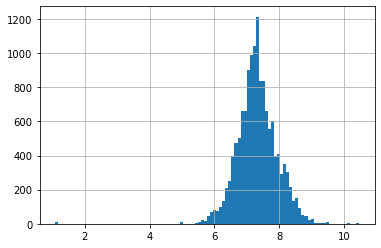

In [77]:
df_train['primary_cleaner.input.feed_size'].hist(bins=100);

<AxesSubplot:>

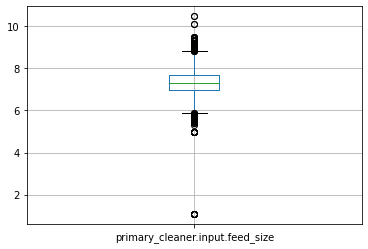

In [78]:
df_train[['primary_cleaner.input.feed_size']].boxplot();

Наблюдаем несколько больших выбросов как в положительную так и в отрицательную (околонулевую) области - они будут сильно влиять на среднее значение

In [79]:
# расчитаем средние
print("Cреднее test:", df_test['primary_cleaner.input.feed_size'].mean())
print("Cреднее train:", df_train['primary_cleaner.input.feed_size'].mean())

Cреднее test: 7.2677500612814585
Cреднее train: 7.325335662817498


Судя по графику, значения равны

С помощью t-test посмотрим насколько значимы различая между нашими значениями.

Нулевая гипотеза: средние значения величин гранул сырья равны

Альтернативная гипотеза: средние значения величин гранул сырья НЕ равны

Подсчитаем наши дисперсии:

In [80]:
disp_test = np.var(df_test['primary_cleaner.input.feed_size'])
print(f'Дисперсия для тестовой выборки = {disp_test}')

disp_train = np.var(df_train['primary_cleaner.input.feed_size'])
print(f'Дисперсия для тренировочной выборки = {disp_train}')

Дисперсия для тестовой выборки = 0.37109223385143686
Дисперсия для тренировочной выборки = 0.37201180310689386


Дисперсии практически одинаковые + данные нормальные => можем применять т-тест

Применяем t-test:

In [81]:
results = st.ttest_ind(df_test['primary_cleaner.input.feed_size'],df_train['primary_cleaner.input.feed_size']) 
results

Ttest_indResult(statistic=-5.828021239705322, pvalue=5.698896664671716e-09)

In [82]:
# критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу


alpha = 0.05
pvalue =alpha/2 


In [83]:
pvalue =results[1]/2 



In [84]:
print('p-значение: ', pvalue)

p-значение:  2.849448332335858e-09


In [85]:
if pvalue < alpha:
    print("Отвергаем нулевую гипотезу: скорее всего размеры гранул сырья не равны")
else:
    print("Не получилось отвергнуть нулевую гипотезу: скорее всего размеры гранул равны")


Отвергаем нулевую гипотезу: скорее всего размеры гранул сырья не равны


Впереди нас ждет очистка данных. Посмотрим на кол-во строк перед очисткой

In [86]:
df_train['primary_cleaner.input.feed_size'].shape

(13895,)

### Почистим наши данные:

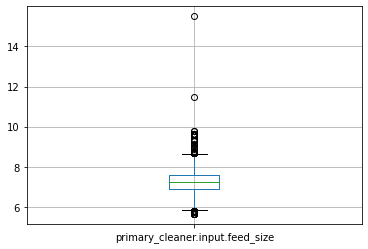

In [87]:
df_test[['primary_cleaner.input.feed_size']].boxplot();


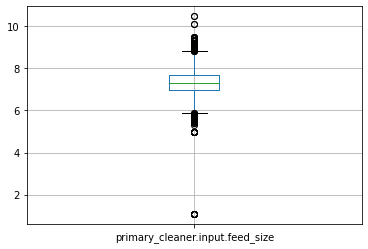

In [88]:
df_train[['primary_cleaner.input.feed_size']].boxplot();


На боксплотах наблюдаем выбросы

In [89]:
df_train[['primary_cleaner.input.feed_size']].describe()

,primary_cleaner.input.feed_size
count,13895.000000
mean,7.325336
std,0.609950
min,1.080000
25%,6.965000
50%,7.293334
75%,7.700000
max,10.470000


Удалим выбросы

In [90]:
test_df=df_test[['primary_cleaner.input.feed_size']]
test_df=test_df.drop(test_df[(test_df['primary_cleaner.input.feed_size']<7)|(test_df['primary_cleaner.input.feed_size']>8.2)].index)
test_df

train_df=df_train[['primary_cleaner.input.feed_size']]
train_df=train_df.drop(train_df[(train_df['primary_cleaner.input.feed_size']<7)|(train_df['primary_cleaner.input.feed_size']>8.2)].index)


Проверим 

<AxesSubplot:>

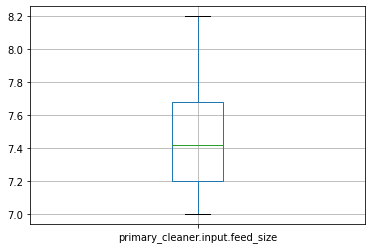

In [91]:
test_df.boxplot();

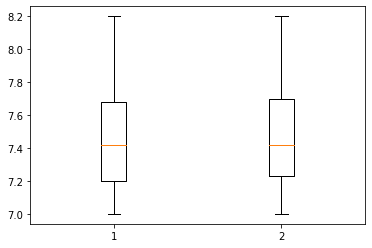

In [92]:
plt.boxplot([test_df['primary_cleaner.input.feed_size'],train_df['primary_cleaner.input.feed_size']]);

In [93]:
# расчитаем средние
print("Cреднее test:", test_df['primary_cleaner.input.feed_size'].mean())
print("Cреднее train:", train_df['primary_cleaner.input.feed_size'].mean())

results = st.ttest_ind(test_df['primary_cleaner.input.feed_size'],train_df['primary_cleaner.input.feed_size']) 
results

Cреднее test: 7.4668433714242015
Cреднее train: 7.472584613660138


Ttest_indResult(statistic=-0.885679455785125, pvalue=0.37580756677443494)

In [94]:
alpha = 0.05
pvalue =alpha/2 
pvalue =results[1]/2 

print('p-значение: ', pvalue)

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу: скорее всего размеры гранул сырья не равны")
else:
    print("Не получилось отвергнуть нулевую гипотезу: скорее всего размеры гранул равны")

p-значение:  0.18790378338721747
Не получилось отвергнуть нулевую гипотезу: скорее всего размеры гранул равны


Если удалить часть данных , то при p-уровне значимости = 5% гранулы равны

Посмотрим какое кол-во данных у нас осталось после "чистки"

In [95]:
train_df.shape

(9036, 1)

Мы потеряли примерно 35% данных, что довольно много. Выбирем вариант где мы просто убираем размеры гранул из обучения

In [96]:
df_train['primary_cleaner.input.feed_size'].shape

(13895,)

#### Cравнение необработанных гранул 

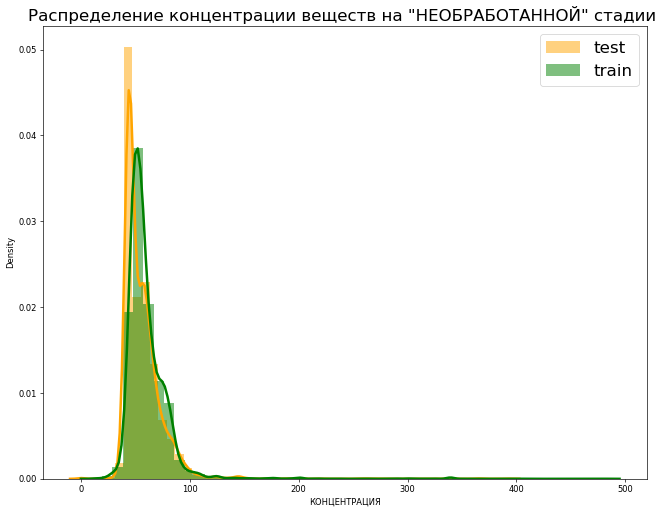

In [97]:
plt.figure(figsize=(13,10), dpi= 60)
sns.distplot(df_test['rougher.input.feed_size'], color="orange", label="test",
             hist_kws={'alpha':.5}, kde_kws={'linewidth':3})


sns.distplot(df_train['rougher.input.feed_size'], color="g", label="train",
             hist_kws={'alpha':.5}, kde_kws={'linewidth':3},axlabel='КОНЦЕНТРАЦИЯ')

plt.title('Распределение концентрации веществ на "НЕОБРАБОТАННОЙ" стадии ', fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [98]:
rougher_test=df_test['rougher.input.feed_size']
rougher_test

0       62.710452
1       61.961163
2       66.903807
3       59.865919
4       63.315324
          ...    
5241    66.758479
5242    62.560684
5243    73.647513
5244    78.066446
5245    77.678700
Name: rougher.input.feed_size, Length: 5246, dtype: float64

In [99]:
rougher_train=df_train['rougher.input.feed_size']
rougher_train

0         55.486599
1         57.278666
2         57.510649
3         57.792734
4         56.047189
            ...    
14144     85.718304
14145    119.499241
14146    122.262690
14147    123.742430
14148     94.544358
Name: rougher.input.feed_size, Length: 13895, dtype: float64

In [100]:
# расчитаем средние значения и дисперсию
print("Cреднее test:", rougher_test.mean())
print("Cреднее train:", rougher_train.mean())

disp_test = np.var(df_test['rougher.input.feed_size'])
print(f'Дисперсия для тестовой выборки = {disp_test}')

disp_train = np.var(df_train['rougher.input.feed_size'])
print(f'Дисперсия для тренировочной выборки = {disp_train}')

Cреднее test: 55.96160384911488
Cреднее train: 60.150947172785536
Дисперсия для тестовой выборки = 361.5210334968026
Дисперсия для тренировочной выборки = 496.48703398112855


  Видим что дисперсия сильно отличается. Т-тест проводить на таких данных нельзя

Выводы:

Размеры гранул до обработки немного отличаются, однако после их обработки разница практически отсутствует.
Проанализировав данный вопрос при помощи p-value получили следующие результаты:
   - после удаления части выбросов тест на "размерах данных после обработки" дал результат, что размеры гранул равны, однако потеря данных (35%) слишком велика, поэтому просто не будем использовать данную фичу в своих расчетах
   
Применить т-тест к гранулам до обработки не получилось из-за большой разницы дисперсий и как следствие эту фичу тоже исключим

### 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

In [108]:
df_full[['rougher.input.feed_au','primary_cleaner.output.concentrate_au','final.output.concentrate_au']].describe()

,rougher.input.feed_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
count,19119.000000,19119.000000,19119.000000
mean,8.286290,32.151578,44.218935
std,1.945772,5.528323,4.672843
min,0.010000,0.000000,0.000000
25%,6.867013,30.479819,43.452289
50%,8.146117,32.838610,45.026128
75%,9.783323,35.038251,46.288209
max,13.731330,45.933934,52.756638


#### Рассмотрим как менялось соотношение концентрации вещ-в на каждой стадии обработки

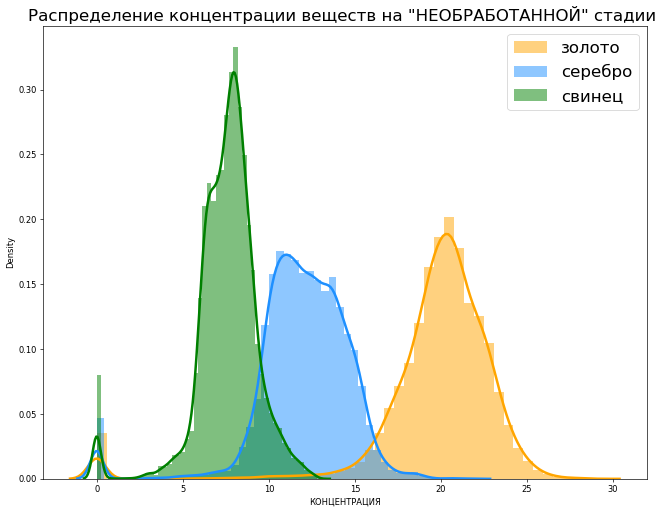

In [109]:
plt.figure(figsize=(13,10), dpi= 60)
sns.distplot(df_full['rougher.output.concentrate_au'], color="orange", label="золото",
             hist_kws={'alpha':.5}, kde_kws={'linewidth':3})

sns.distplot(df_full['rougher.output.concentrate_ag'], color="dodgerblue", label="серебро",
             hist_kws={'alpha':.5}, kde_kws={'linewidth':3})

sns.distplot(df_full['rougher.output.concentrate_pb'], color="g", label="свинец",
             hist_kws={'alpha':.5}, kde_kws={'linewidth':3},axlabel='КОНЦЕНТРАЦИЯ')

plt.title('Распределение концентрации веществ на "НЕОБРАБОТАННОЙ" стадии ', fontsize=20)
plt.legend(fontsize=20)
plt.show()

По концентрации веществ на "необработанной" стадии:
  - золото боле всего - всетаки золотосодержащая руда
  - на втором месте серебро
  - на третьем месте свинец

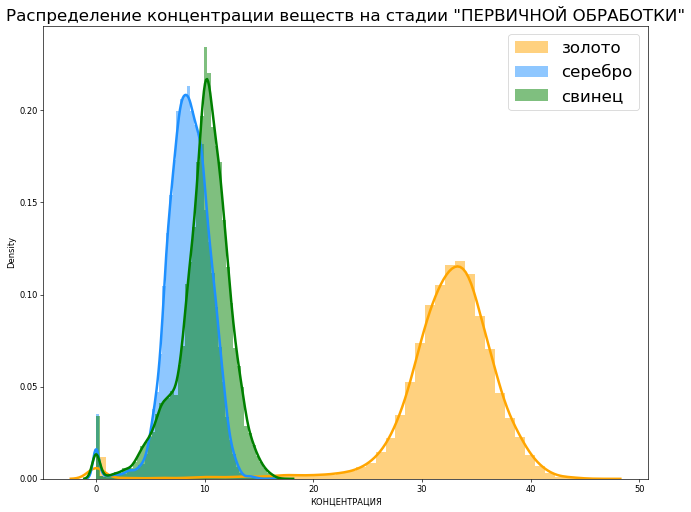

In [110]:
plt.figure(figsize=(13,10), dpi= 60)
sns.distplot(df_full['primary_cleaner.output.concentrate_au'], color="orange", label="золото",
             hist_kws={'alpha':.5}, kde_kws={'linewidth':3})

sns.distplot(df_full['primary_cleaner.output.concentrate_ag'], color="dodgerblue", label="серебро",
             hist_kws={'alpha':.5}, kde_kws={'linewidth':3})

sns.distplot(df_full['primary_cleaner.output.concentrate_pb'], color="g", label="свинец",
             hist_kws={'alpha':.5}, kde_kws={'linewidth':3},axlabel='КОНЦЕНТРАЦИЯ')

plt.title('Распределение концентрации веществ на стадии "ПЕРВИЧНОЙ ОБРАБОТКИ"', fontsize=20)
plt.legend(fontsize=20)
plt.show()

По концентрации веществ на стадии "первичной обработки":
  - на первом месте золото
  - разница между концентрациями свинца и серебра минимальна (в пользу свинца)

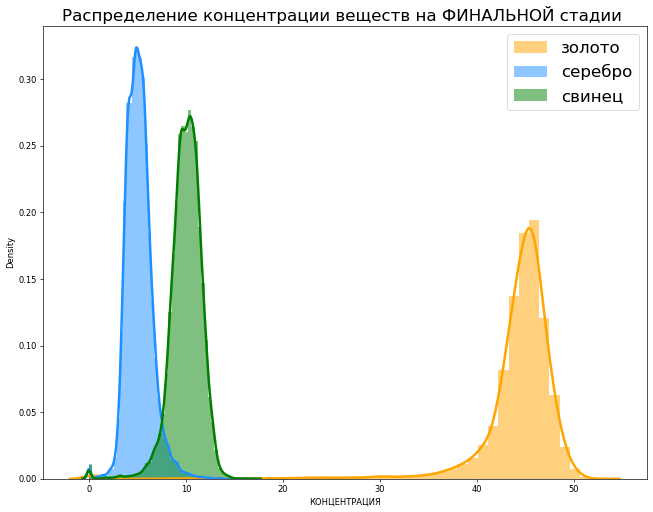

In [111]:
plt.figure(figsize=(13,10), dpi= 60)
sns.distplot(df_full['final.output.concentrate_au'], color="orange", label="золото",
             hist_kws={'alpha':.5}, kde_kws={'linewidth':3})

sns.distplot(df_full['final.output.concentrate_ag'], color="dodgerblue", label="серебро",
             hist_kws={'alpha':.5}, kde_kws={'linewidth':3})

sns.distplot(df_full['final.output.concentrate_pb'], color="g", label="свинец",
             hist_kws={'alpha':.5}, kde_kws={'linewidth':3},axlabel='КОНЦЕНТРАЦИЯ')

plt.title('Распределение концентрации веществ на ФИНАЛЬНОЙ стадии ', fontsize=20)
plt.legend(fontsize=20)
plt.show()

По концентрации веществ на стадии "финальной обработки":
  - высокая концентрация золота
  - на втором свинец 
  - на третьем месте серебро

#### Рассмотрим как менялось содержание каждого вещ-ва в зависимости от стадии

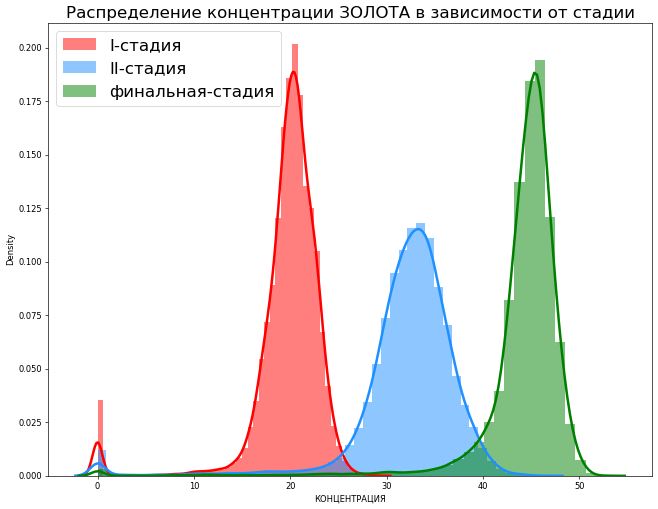

In [112]:
plt.figure(figsize=(13,10), dpi= 60)
sns.distplot(df_full['rougher.output.concentrate_au'], color="red", label="I-стадия",
             hist_kws={'alpha':.5}, kde_kws={'linewidth':3})

sns.distplot(df_full['primary_cleaner.output.concentrate_au'], color="dodgerblue", label="II-стадия",
             hist_kws={'alpha':.5}, kde_kws={'linewidth':3})

sns.distplot(df_full['final.output.concentrate_au'], color="g", label="финальная-стадия",
             hist_kws={'alpha':.5}, kde_kws={'linewidth':3},axlabel='КОНЦЕНТРАЦИЯ')

plt.title('Распределение концентрации ЗОЛОТА в зависимости от стадии', fontsize=20)
plt.legend(fontsize=20)
plt.show()

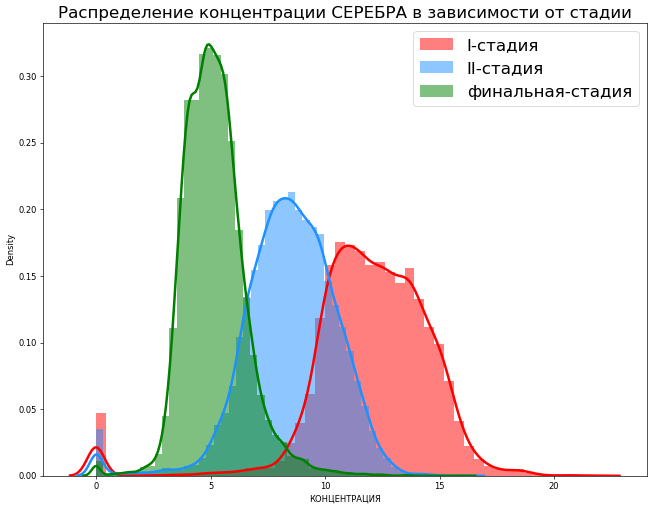

In [113]:
plt.figure(figsize=(13,10), dpi= 60)
sns.distplot(df_full['rougher.output.concentrate_ag'], color="red", label="I-стадия",
             hist_kws={'alpha':.5}, kde_kws={'linewidth':3})

sns.distplot(df_full['primary_cleaner.output.concentrate_ag'], color="dodgerblue", label="II-стадия",
             hist_kws={'alpha':.5}, kde_kws={'linewidth':3})

sns.distplot(df_full['final.output.concentrate_ag'], color="g", label="финальная-стадия",
             hist_kws={'alpha':.5}, kde_kws={'linewidth':3},axlabel='КОНЦЕНТРАЦИЯ')

plt.title('Распределение концентрации СЕРЕБРА в зависимости от стадии', fontsize=20)
plt.legend(fontsize=20)
plt.show()

Значения возле нуля могут говорить о том, что какие то вещ-ва отсутствуют. Это конечно немного смущает, но ведь может быть такая ситуация, когда мы вычистили наше золото от всех примесей, во всяком случае до точности распознования этих примесей оборудованием.   

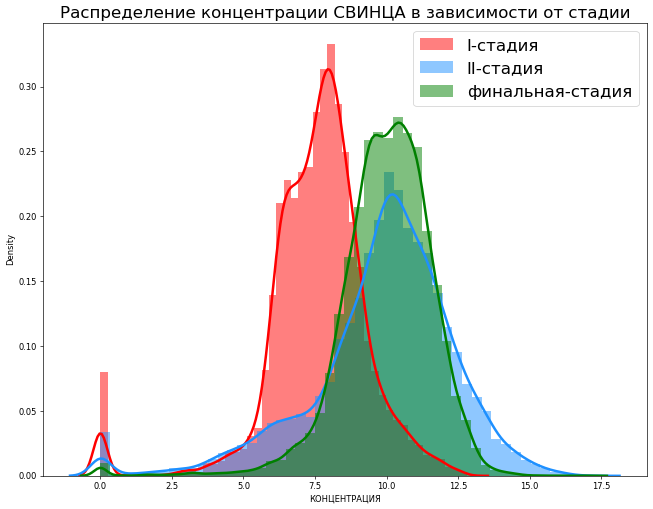

In [114]:
plt.figure(figsize=(13,10), dpi= 60)
sns.distplot(df_full['rougher.output.concentrate_pb'], color="red", label="I-стадия",
             hist_kws={'alpha':.5}, kde_kws={'linewidth':3})

sns.distplot(df_full['primary_cleaner.output.concentrate_pb'], color="dodgerblue", label="II-стадия",
             hist_kws={'alpha':.5}, kde_kws={'linewidth':3})

sns.distplot(df_full['final.output.concentrate_pb'], color="g", label="финальная-стадия",
             hist_kws={'alpha':.5}, kde_kws={'linewidth':3},axlabel='КОНЦЕНТРАЦИЯ')

plt.title('Распределение концентрации СВИНЦА в зависимости от стадии', fontsize=20)
plt.legend(fontsize=20)
plt.show()

Выводы: Технология добычи золота сильно влияет на:
  - золото - в пользу увеличении его концентрации на каждом технологическом этапе
  - серебро - в сторону уменьшения его концентрации на каждом технологическом этапе

На концентрацию свинца влияет слабо: сначала небольшое увеличение концентрации, но потом никаких существенных изменений

### Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

Создадим столбцы с суммарными значениями всех веществ

In [115]:
df_train['rougher.output.concentrate_all'] = df_train['rougher.output.concentrate_au'] + df_train['rougher.output.concentrate_ag'] + df_train['rougher.output.concentrate_pb'] + df_train['rougher.output.concentrate_sol']
df_train['primary_cleaner.output.concentrate_all'] = df_train['primary_cleaner.output.concentrate_au'] + df_train['primary_cleaner.output.concentrate_ag'] + df_train['primary_cleaner.output.concentrate_pb'] + df_train['primary_cleaner.output.concentrate_sol']
df_train['final.output.concentrate_all'] = df_train['final.output.concentrate_au'] + df_train['final.output.concentrate_ag'] + df_train['final.output.concentrate_pb'] + df_train['final.output.concentrate_sol']

df_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.concentrate_all,primary_cleaner.output.concentrate_all,final.output.concentrate_all
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,66.424950,72.640924,63.644396
1,2016-01-15 01:00:00,6.0

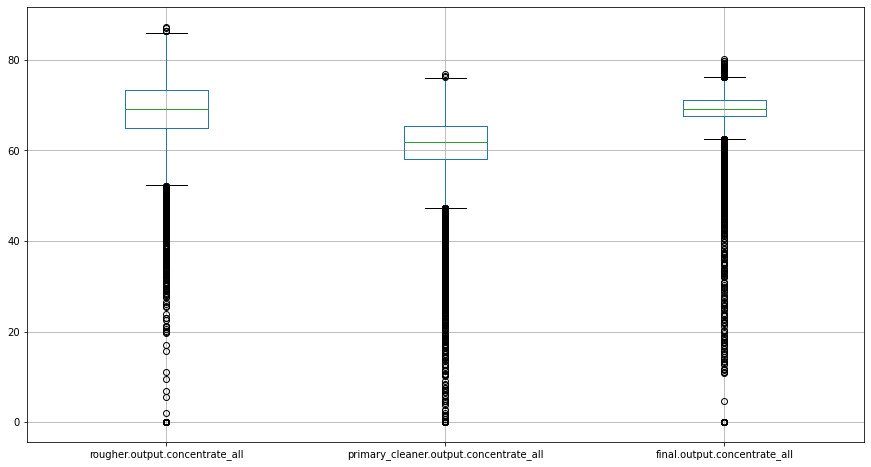

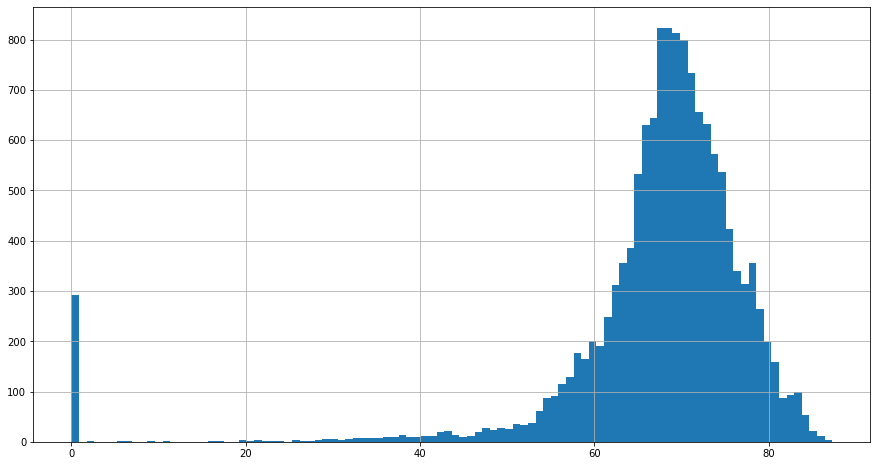

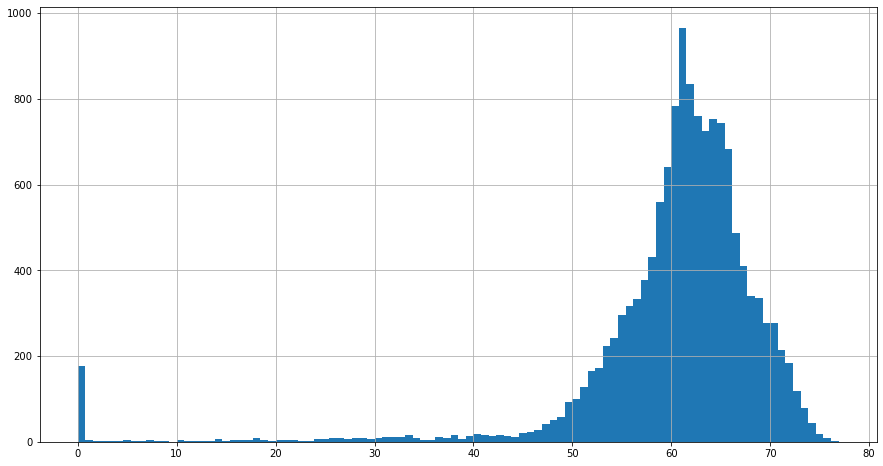

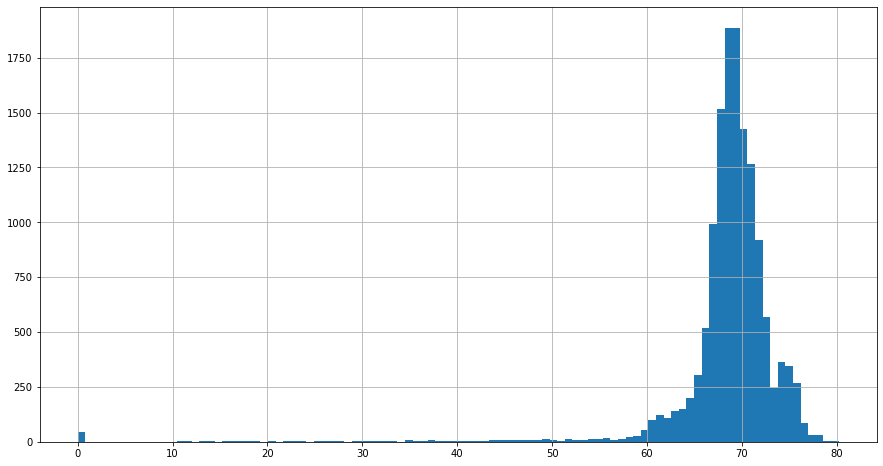

In [116]:
plt.figure(figsize=(15, 8))
df_train[['rougher.output.concentrate_all', 'primary_cleaner.output.concentrate_all', 'final.output.concentrate_all']].boxplot()
plt.show()
plt.figure(figsize=(15, 8))
df_train['rougher.output.concentrate_all'].hist(bins=100)
plt.show()
plt.figure(figsize=(15, 8))
df_train['primary_cleaner.output.concentrate_all'].hist(bins=100)
plt.show()
plt.figure(figsize=(15, 8))
df_train['final.output.concentrate_all'].hist(bins=100)
plt.show()

удалим строки в который суммарная концентрация околонулевая

In [117]:
df_train = df_train.drop(df_train[(df_train['rougher.output.concentrate_all'] < 20)].index)
df_train = df_train.drop(df_train[(df_train['primary_cleaner.output.concentrate_all'] < 20)].index)
df_train = df_train.drop(df_train[(df_train['final.output.concentrate_all'] < 20)].index)


Еще раз взглянем на данные

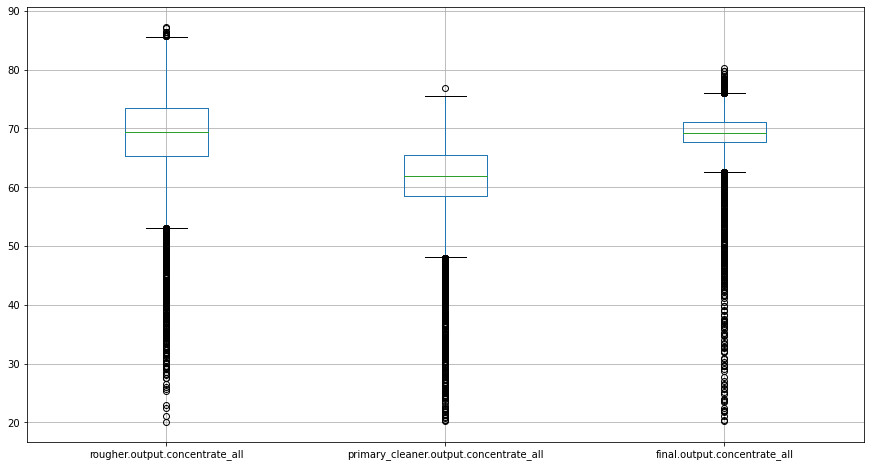

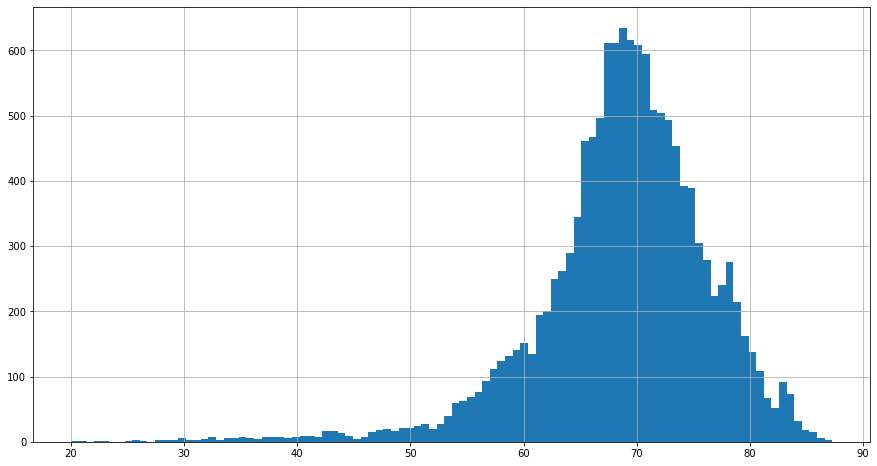

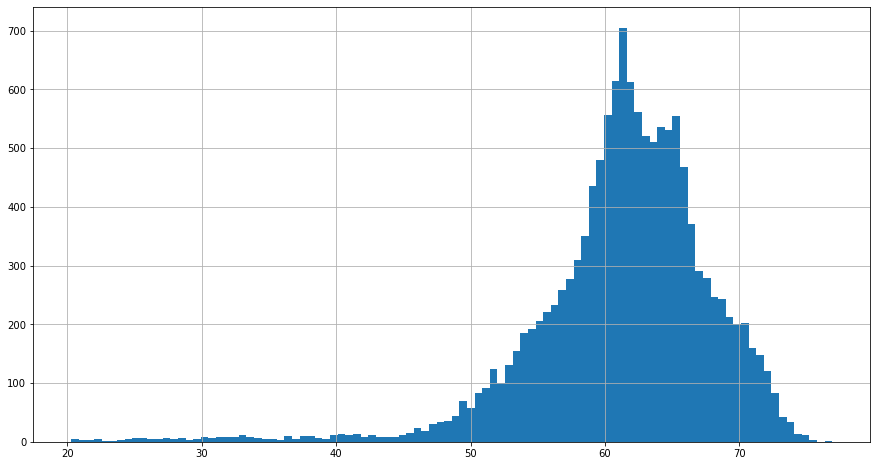

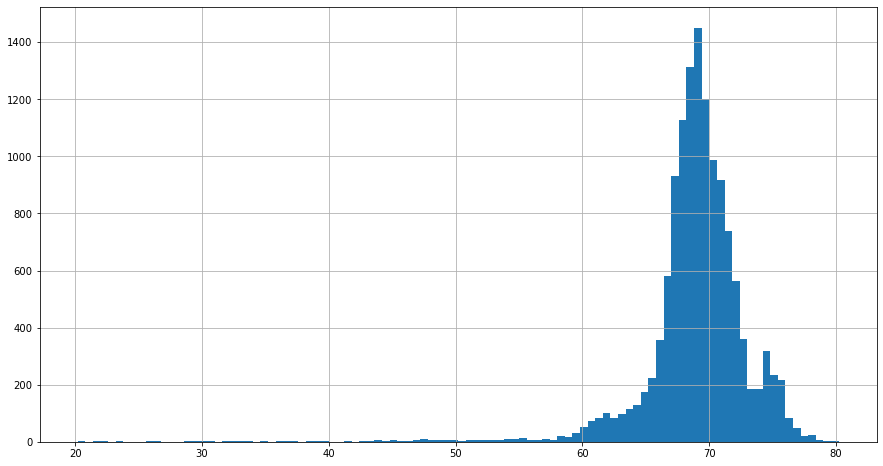

In [118]:
plt.figure(figsize=(15, 8))
df_train[['rougher.output.concentrate_all', 'primary_cleaner.output.concentrate_all', 'final.output.concentrate_all']].boxplot()
plt.show()
plt.figure(figsize=(15, 8))
df_train['rougher.output.concentrate_all'].hist(bins=100)
plt.show()
plt.figure(figsize=(15, 8))
df_train['primary_cleaner.output.concentrate_all'].hist(bins=100)
plt.show()
plt.figure(figsize=(15, 8))
df_train['final.output.concentrate_all'].hist(bins=100)
plt.show()

Выводы: околонулевые значения удалили

## 3. Построим модель

### 3.1. Напишите функцию для вычисления итоговой sMAPE.

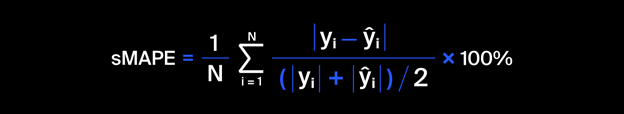

Итоговая метрика складывается из двух величин:
    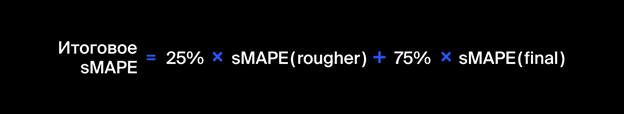

In [119]:
def sMAPE(y_pred, y_real):
    
    smape_rougher = np.sum(np.abs(y_real[:, 0] - y_pred[:, 0]) / 
                           (np.abs(y_real[:, 0]) + np.abs(y_pred[:, 0]) / 2)) * 100 / y_pred.shape[0]
    
    smape_final = np.sum(np.abs(y_real[:, 1] - y_pred[:, 1]) / 
                         (np.abs(y_real[:, 1]) + np.abs(y_pred[:, 1]) / 2)) * 100 / y_pred.shape[0]
    
    return 0.25 * smape_rougher + 0.75 * smape_final

In [120]:
custom_score = make_scorer(sMAPE,greater_is_better=False)
custom_score

make_scorer(sMAPE, greater_is_better=False)

Функцию sMAPE написали!

### 3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

Выберем те фичи для обучающей выборки которые есть в тестовой.

In [121]:
train_features = df_test.columns.tolist()

In [122]:
df_train = df_train[train_features]

Разобьем выборки на фичи и таргетные значения

In [124]:
X_train = df_train.drop(['date','rougher.output.recovery', 'final.output.recovery'], axis = 1)
X_test = df_test.drop(['date','rougher.output.recovery', 'final.output.recovery'], axis = 1)
y_train = df_train[['rougher.output.recovery', 'final.output.recovery']].to_numpy()
y_test = df_test[['rougher.output.recovery', 'final.output.recovery']].to_numpy()

Создадим модель случайного леса. в качестве параметров будем варьировать кол-вом редевьев и глубиной деревьев. Кросс валидацию сделаем с 5 фолдами.

In [125]:
clf_rf_cv = RandomForestRegressor(random_state = 12345)
parametrs = {
    'n_estimators':range(30,40,5),
    'max_depth':range(2,5),
},
n_jobs = -1,

gr = GridSearchCV(clf_rf_cv,parametrs, cv = 5,scoring = custom_score)

In [126]:
gr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             param_grid=({'max_depth': range(2, 5),
                          'n_estimators': range(30, 40, 5)},),
             scoring=make_scorer(sMAPE, greater_is_better=False))

In [127]:
print(f"Лучшее параметры модели: {(gr.best_params_)}")

print(f"Лучшее качество модели по метрике sMAPE: {np.abs(gr.best_score_)}")


Лучшее параметры модели: {'max_depth': 4, 'n_estimators': 35}
Лучшее качество модели по метрике sMAPE: 5.527705757164763


Модель линейной регрессии

In [128]:
model_L = GridSearchCV(LinearRegression(),param_grid = {},cv = 5,n_jobs = -1,scoring = custom_score)
model_L.fit(X_train, y_train)

print(f"Лучшее качество модели по метрике sMAPE: {abs(model_L.best_score_)}")

Лучшее качество модели по метрике sMAPE: 6.5103278195913985


#### В работе ранее мы говорили о том что необходимо удалить фичу:"размеры гранул", т.к. средние значения теста и трейна различаются

Удалим параметры размера гранул

In [129]:
X_train = X_train.drop(['primary_cleaner.input.feed_size','rougher.input.feed_size'], axis = 1)
X_test = X_test.drop(['primary_cleaner.input.feed_size','rougher.input.feed_size'], axis = 1)

Снова построим модели случайного леса и линейной регрессии и посмотрим что будет

In [130]:
clf_rf_cv = RandomForestRegressor(random_state = 12345)
parametrs = {
    'n_estimators':range(30,40,5),
    'max_depth':range(2,5),
},
n_jobs = -1,

gr = GridSearchCV(clf_rf_cv,parametrs, cv = 5,scoring = custom_score)
gr.fit(X_train, y_train)

print(f"Лучшее параметры модели: {(gr.best_params_)}")

print(f"Лучшее качество модели по метрике sMAPE: {np.abs((gr.best_score_))}")



Лучшее параметры модели: {'max_depth': 4, 'n_estimators': 35}
Лучшее качество модели по метрике sMAPE: 5.535511997135916


 Модель линейной регрессии

In [131]:
model_L = GridSearchCV(LinearRegression(),param_grid={},cv=5,n_jobs=-1,scoring=custom_score)
model_L.fit(X_train, y_train)

print(f"Лучшее качество модели по метрике sMAPE: {abs(model_L.best_score_)}")

Лучшее качество модели по метрике sMAPE: 6.511944207945739


 Наилучший результат показа модель случайного леса, её мы и используем на тестовой выборке

Тестовая выборка

In [132]:
final_model =RandomForestRegressor(random_state=12345, n_estimators=35, max_depth=4)

In [133]:
final_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=35, random_state=12345)

In [134]:
pred = final_model.predict(X_test)

In [135]:
sMAPE(pred, y_test)

6.358773992966482

Посмотрим какие признаки оказались наиболее важными для нашей модели

<AxesSubplot:xlabel='feature'>

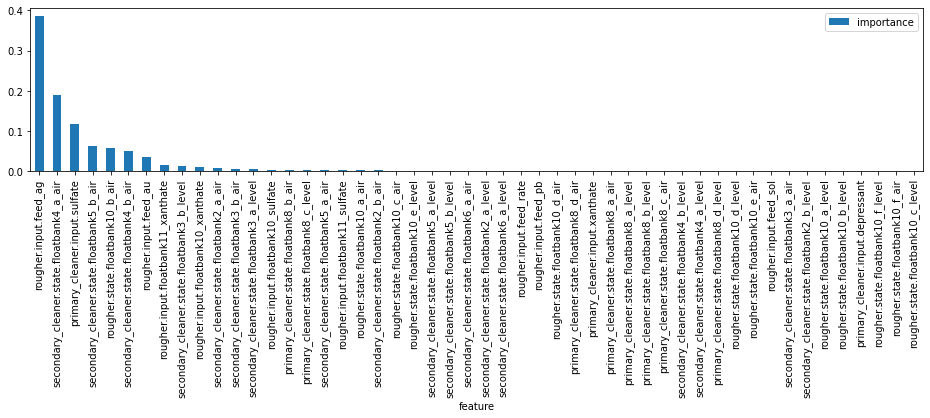

In [136]:
importances = pd.DataFrame({'feature':X_test.columns,'importance':np.round(final_model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar(figsize=(16, 3));

In [137]:
importances.head(3)

,importance
feature,
rougher.input.feed_ag,0.386
secondary_cleaner.state.floatbank4_a_air,0.190
primary_cleaner.input.sulfate,0.117


самыми важными фичами оказались:
  - rougher.input.feed_ag - I место
  - secondary_cleaner.state.floatbank4_a_air - II место
  - primary_cleaner.input.sulfate - III место

### Инициализируем и обучим константную модель¶


In [138]:
dc = DummyRegressor()
model_dc = dc.fit(X_train, y_train)
y_pred_test = model_dc.predict(X_test)
print(f'sMAPE Dummy Regressor (на тесте): {sMAPE(y_pred_test, y_test)}')

sMAPE Dummy Regressor (на тесте): 6.720560426186391


Константная модель даёт значение чуть хуже, чем полученное на тесте, значит можем думать что наша модель работает лучше

### Вывод:

 - Итоговая модель построена на алгоритме RandomForestRegressor
 - Параметры алгоритма: n_estimators=35, max_depth=4
 - Параметр recovery в тренировочной выборке был рассчитан верно
